In [10]:
# Import packages and set numpy random seed
import numpy as np
np.random.seed(5) 
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#for GPU training
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

tf.random.set_seed(2)

import matplotlib.pyplot as plt
%matplotlib inline



#load data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2,
    horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '../../ddd_images_train/drowsiness-scale',
    target_size=(64, 64),
    batch_size=16,
    shuffle=True,
    subset='training',
    class_mode='binary')

# print(train_generator)

validation_generator = train_datagen.flow_from_directory(
    '../../ddd_images_train/drowsiness-scale',
    target_size=(64, 64),
    batch_size=16,
    shuffle=True,
    subset='validation',
    class_mode='binary')


# test_generator = test_datagen.flow_from_directory(
#     '../../ddd_images_test/drowsiness-scale',
#     target_size=(144, 144),
#     batch_size=96,
#     shuffle=True,
#     class_mode='binary')


Found 568740 images belonging to 2 classes.
Found 142183 images belonging to 2 classes.


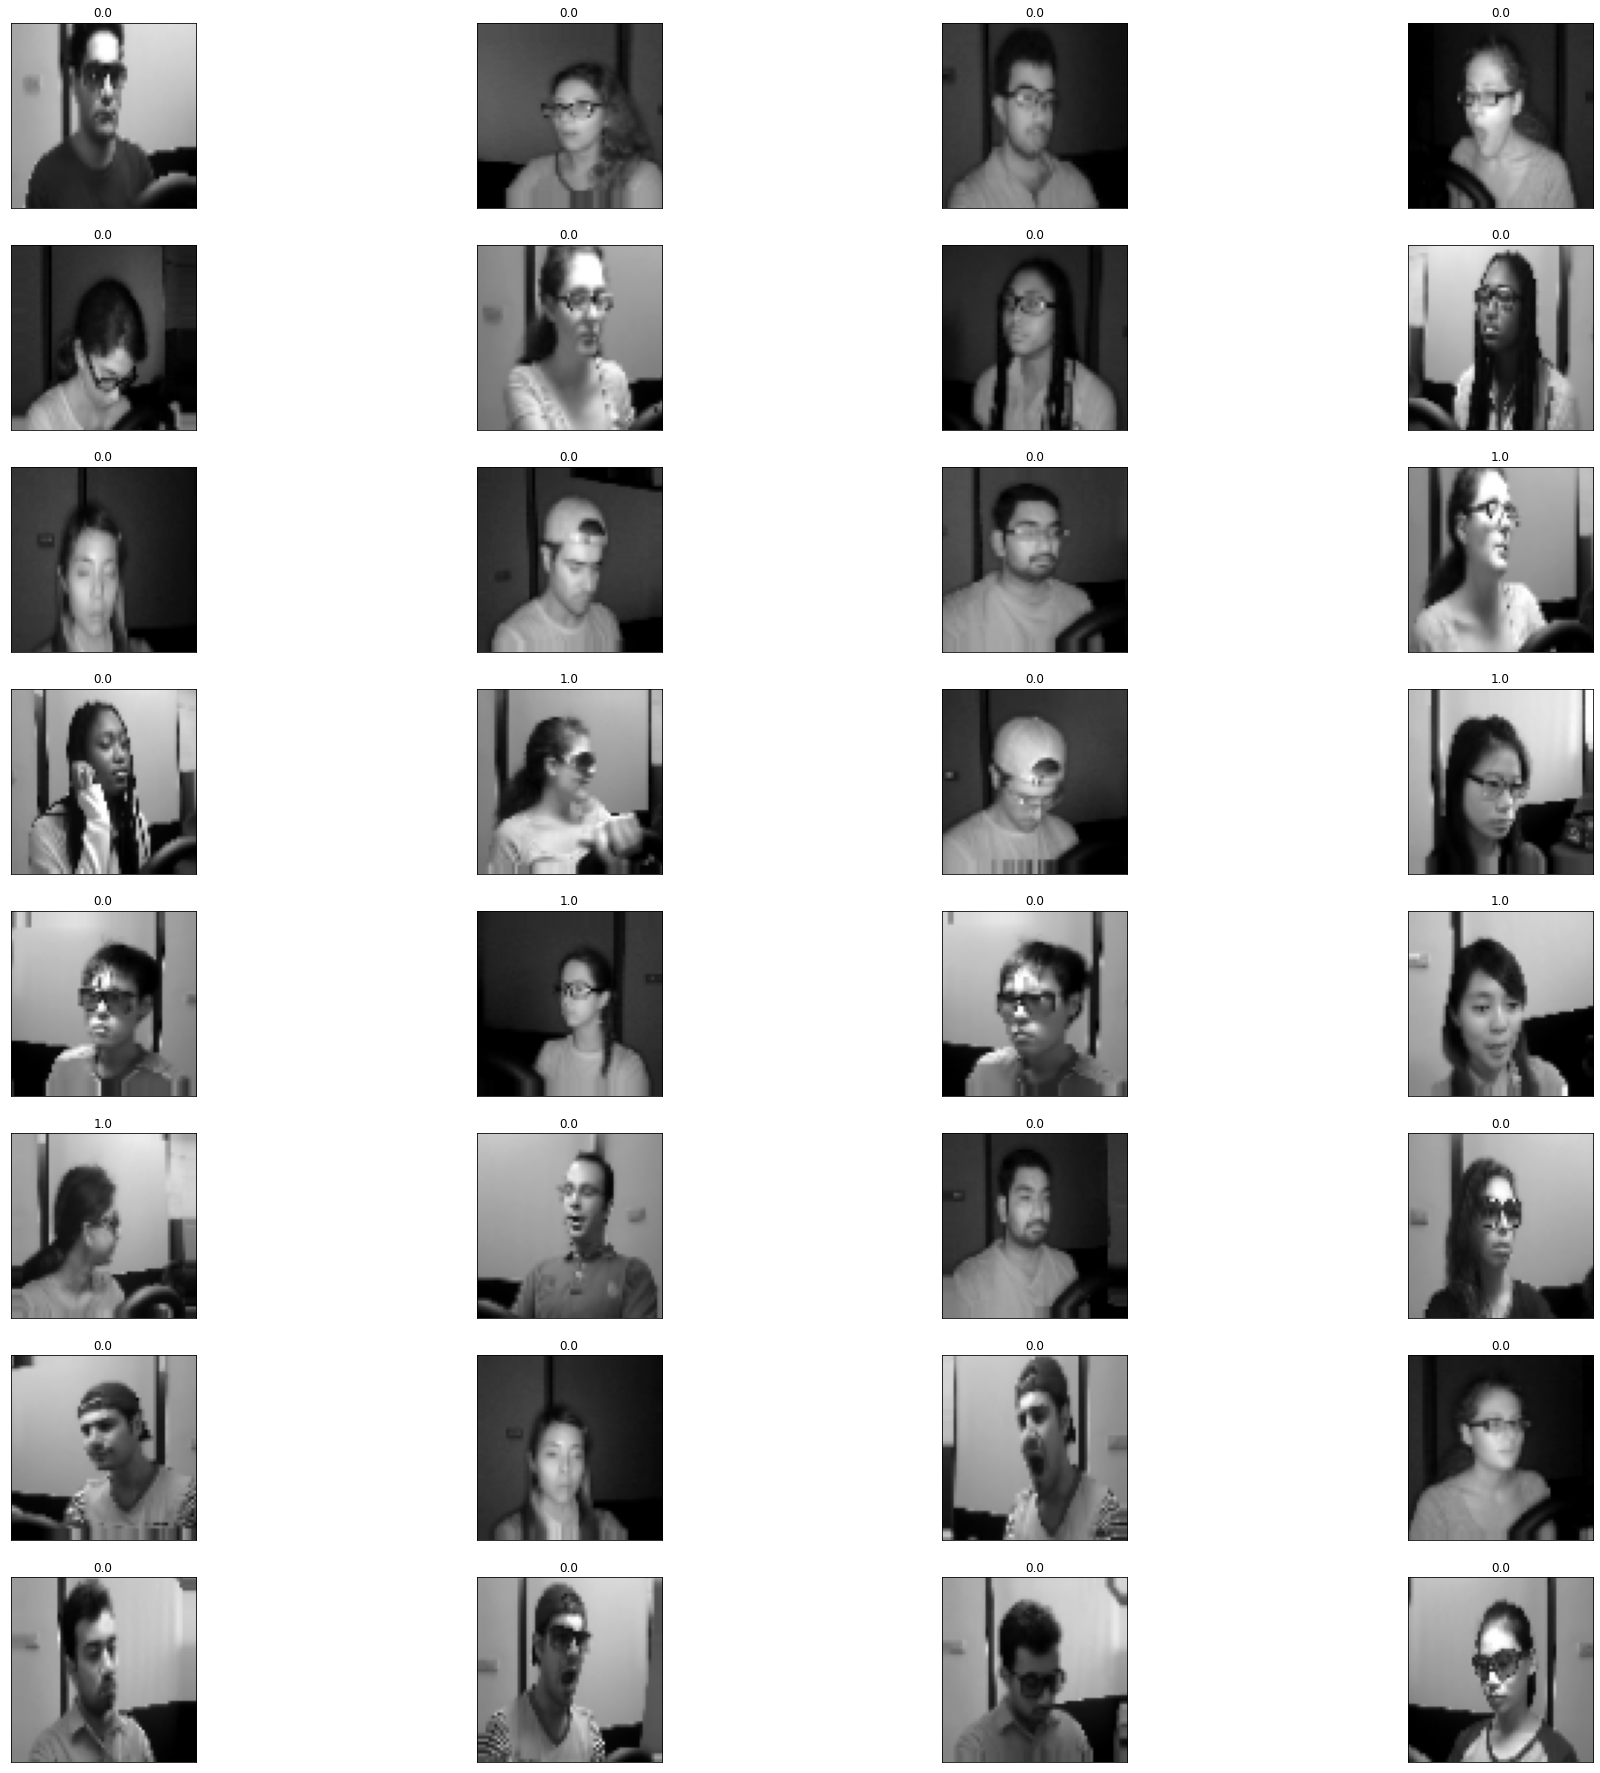

In [4]:
x,y = train_generator.next()
fig = plt.figure(figsize=(32,32))
for i in range(0,32):
    ax = fig.add_subplot(8, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x[i]))
    ax.set_title("{}".format(y[i]))
plt.show()

#1 is non drowsy, 0 is drowsy

In [3]:
# print(train_generator.shape[0])

# chat_data = train_generator.diagnosis.value_counts()
# chat_data.plot(kind='bar');
# plt.title('Sample Per Class');
# plt.show()
# plt.pie(chat_data, autopct='%1.1f%%', shadow=True, labels=["Drowsy", "Non-drowsy"])
# plt.title('Per class sample Percentage');
# plt.show()

In [4]:
# model = tf.keras.applications.ResNet50V2(
#     include_top=False, weights='imagenet', input_tensor=None,
#     input_shape=(144,144,3), pooling='max', classes=2,
#     classifier_activation='sigmoid'
# )
# model.summary()

In [5]:
from helper import SEResNet
import keras

model = SEResNet(input_shape=(64,64,3), classes = 1)

model.summary()
# model.compile()

optimizer = keras.optimizers.Adam(lr=0.0001)
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True) #from_logits=True means output probabilities are not normalized
acc_metric = keras.metrics.BinaryAccuracy()
val_acc_metric = keras.metrics.BinaryAccuracy()
val_loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

Model: "resnext"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 32, 32, 64)   9408        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 64)   0           conv2d_72[0][0]                  
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 16, 16, 64)   256         max_pooling2d_2[0][0]            
____________________________________________________________________________________________

In [6]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training = True)

        loss = loss_fn(y, y_pred)
        
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    acc_metric.update_state(y, y_pred)
    
    
    return loss, y_pred

@tf.function
def test_step(x, y):
    val_preds = model(x, training=False)
    loss = val_loss_fn(y, val_preds)
    
    # Update val metrics
    val_acc_metric.update_state(y, val_preds)
    return val_preds, loss

In [7]:
import cv2


def put_text(imgs, actuals, preds):
    result = np.empty_like(imgs)
    for i in range(imgs.shape[0]):
        actual = actuals[i]
        pred = preds[i]
        if isinstance(actual, bytes):
            actual = actual.decode()
            
        if isinstance(pred, bytes):
            pred = pred.decode() 
        # You may need to adjust text size and position and size.
        # If your images are in [0, 255] range replace (0, 0, 1) with (0, 0, 255)
        
        result[i, :, :, :] = cv2.putText(imgs[i, :, :, :], str(actual), (0, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
        result[i, :, :, :] = cv2.putText(result[i, :, :, :], str(pred), (0, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
    return result


In [8]:
import io

def plot_fig(fpr,tpr,roc_auc):
    fig = plt.figure()
#     print(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Diagram')
    plt.legend(loc="lower right")
    #store
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image
    


Start of Training Epoch 0
35546
epoch 0, batch 0 loss = 1.1257617473602295, accuracy = 0.28125
epoch 0, batch 50 loss = 0.8757617473602295, accuracy = 0.41225960850715637
epoch 0, batch 100 loss = 0.9382617473602295, accuracy = 0.4166666567325592
Accuracy over epoch 0.4166666567325592
Validation acc in valid batch 0: 0.5000
Validation acc in valid batch 50: 0.4007
Validation acc in valid batch 100: 0.4165
Validation acc: 0.4165

Start of Training Epoch 1
35546
epoch 1, batch 0 loss = 1.0007617473602295, accuracy = 0.3125
epoch 1, batch 50 loss = 1.0007617473602295, accuracy = 0.4325980246067047
epoch 1, batch 100 loss = 0.9382617473602295, accuracy = 0.42512375116348267
Accuracy over epoch 0.42512375116348267
Validation acc in valid batch 0: 0.4375
Validation acc in valid batch 50: 0.3983
Validation acc in valid batch 100: 0.4066
Validation acc: 0.4066

Start of Training Epoch 2
35546
epoch 2, batch 0 loss = 1.0007617473602295, accuracy = 0.3125
epoch 2, batch 50 loss = 0.750761747360

KeyboardInterrupt: 

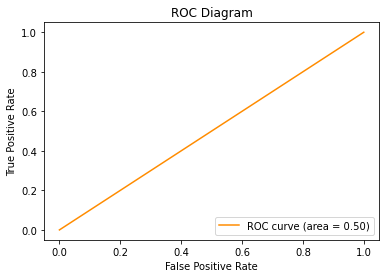

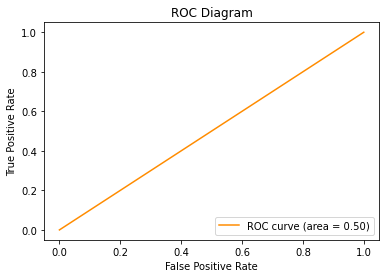

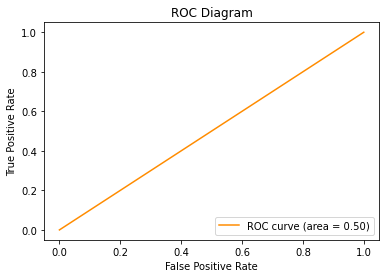

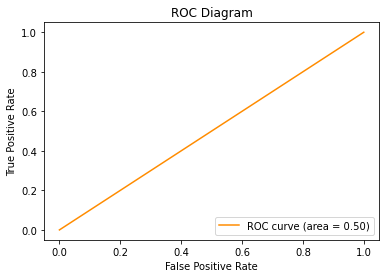

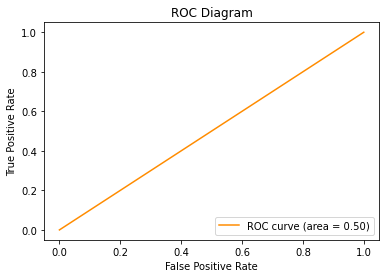

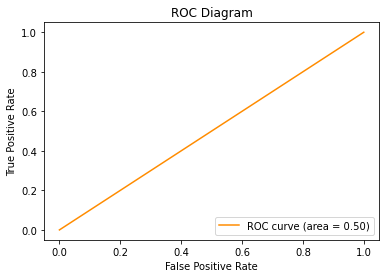

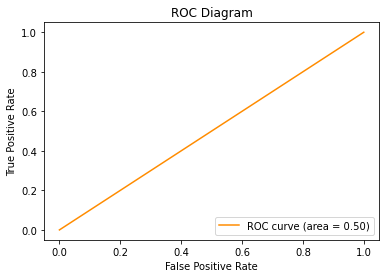

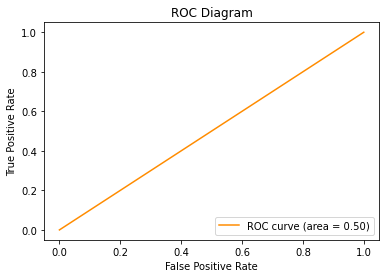

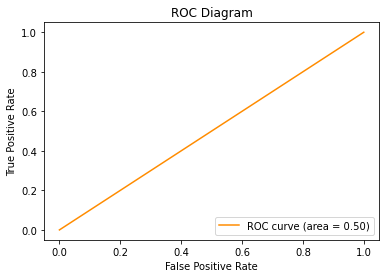

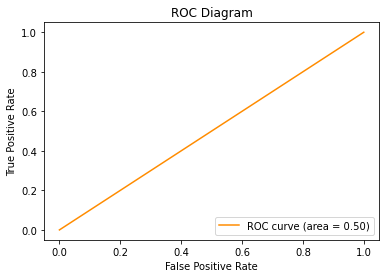

In [11]:
#todo: store tpr and fpr in arrays for each epoch and take their avg (sum/totalNo.)
#plot roc auc for that and store in tensorboard
from datetime import datetime

from sklearn.metrics import roc_curve, auc

num_epochs = 10

train_writer = tf.summary.create_file_writer('logs/SEModel/train', max_queue = 10)
valid_writer = tf.summary.create_file_writer('logs/SEModel/validation', max_queue = 10)

total_train_files = 0
total_valid_files = 0



for epoch in range(num_epochs):
    print(f"\nStart of Training Epoch {epoch}")
    print(train_generator.samples//16)
    #empty at the begining of every epoch
    fpr=[]
    tpr=[]
    
    valid_tpr=[]
    valid_fpr=[]
    for batch_idx in range(train_generator.samples//16):
        recent_batch = train_generator.next()
        x_batch = recent_batch[0]
        y_batch = recent_batch[1]
        
        loss_value, y_pred = train_step(x_batch, y_batch)
        #change (1,16) to (1,batch_number)
        y_preds = np.reshape(tf.get_static_value(y_pred),(1,16))[0]
#         print(y_batch, y_preds)
        
        if batch_idx % 50 == 0:
            print(f"epoch {epoch}, batch {batch_idx} loss = {loss_value}, accuracy = {acc_metric.result()}")
      
            train_acc = acc_metric.result()
            #for roc
            batch_fpr, batch_tpr, _ = roc_curve(y_batch, y_preds)

            for i in range(len(batch_fpr)):
                fpr.append(batch_fpr[i])
                tpr.append(batch_tpr[i])
            
            
            with train_writer.as_default():
                tf.summary.scalar("train_accuracy", train_acc,step = total_train_files)
                tf.summary.scalar("train_loss", loss_value, step = total_train_files)
                
#                 tf.summary.image('roc', roc_img, step=total_train_files)
                
                annotated_images = put_text(x_batch, y_batch, y_preds)
                tf.summary.image('train_images', annotated_images, max_outputs=12, step = total_train_files)
                
                tf.summary.histogram("predicted_output", y_preds, step=total_train_files)
                total_train_files += 50
        if batch_idx%100 == 0 and batch_idx!=0:
            break
                
                
                
                
    roc_auc = auc(np.sort(fpr), np.sort(tpr))
    image = plot_fig(np.sort(fpr), np.sort(tpr), roc_auc)
    with train_writer.as_default():
        tf.summary.image('roc_train', image, step=epoch)
        
    print(f"Accuracy over epoch {train_acc}")
    
    acc_metric.reset_states()
    
    #for validataion at the end of every epoch
    for val_batch_idx in range(validation_generator.samples//16):
        recent_validation_batch = validation_generator.next()
        x_validation_batch = recent_validation_batch[0]
        y_validation_batch = recent_validation_batch[1]
        
        val_y_preds,val_loss = test_step(x_validation_batch,y_validation_batch)
        val_y_pred = np.reshape(tf.get_static_value(val_y_preds),(1,16))[0]
        val_acc = val_acc_metric.result()
        
        if val_batch_idx % 50 == 0:
            print(f"Validation acc in valid batch {val_batch_idx}: %.4f" % (float(val_acc),))
            #for roc
            batch_fpr, batch_tpr,_ = roc_curve(y_validation_batch, val_y_pred)

            for i in range(len(batch_fpr)):
                valid_fpr.append(batch_fpr[i])
                valid_tpr.append(batch_tpr[i])
                
            with valid_writer.as_default():
                tf.summary.scalar("validation_accuracy", val_acc, step=total_valid_files)
                tf.summary.scalar("validation_loss", val_loss, step=total_valid_files)
            total_valid_files += 50
        if val_batch_idx%100 == 0 and val_batch_idx!=0:
            break
    roc_auc = auc(np.sort(fpr), np.sort(tpr))
    valid_roc_image = plot_fig(np.sort(valid_fpr), np.sort(valid_tpr), roc_auc)
    with train_writer.as_default():
        tf.summary.image('roc_valid', valid_roc_image, step=epoch)

    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc)))
    
    model.save_weights(f'{datetime.now().strftime("%d_%m_%Y_%H_%M_%S")} epoch {epoch}.h5')
    
train_writer.close()
valid_writer.close()